In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import (accuracy_score, dcg_score, roc_auc_score, 
                             precision_score, recall_score)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

from htools import assert_raises, save, load
from incendio.core import *
from incendio.callbacks import *
from incendio.metrics import *
from incendio.optimizers import *
from incendio.utils import *

In [ ]:
# Reproducible testing.
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
class Data(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        self.y = torch.clamp(
            (self.x[:, 0]*.75 + self.x[:, 1]*.25).round(), 0, 1
        ).abs().unsqueeze(-1)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [ ]:
class EasyDataset(Dataset):
    
    def __init__(self, n=10, scalar=8):
        """Larger scalar makes data easier to classify."""
        self.x = torch.rand(n).float().unsqueeze(-1)
        self.y = (self.x + torch.randn_like(self.x)/scalar > 0.5).float()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [ ]:
class MulticlassData(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        # Integer labels between 0 and 4, inclusive.
        self.y = torch.clamp(
            torch.round(
                torch.randint(6, (n, 1)).float() 
                * (self.x[:, 0]*.75 + self.x[:, 1]*.25).unsqueeze(-1)
            ), 0, 4).long().flatten()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [ ]:
ypred_ = torch.rand(5, 2)
y_ = torch.tensor([0, 1, 1, 0, 1])
ypred_, y_

(tensor([[0.4963, 0.7682],
         [0.0885, 0.1320],
         [0.3074, 0.6341],
         [0.4901, 0.8964],
         [0.4556, 0.6323]]), tensor([0, 1, 1, 0, 1]))

In [ ]:
class SimpleModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 2)
        self.fc2 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class GroupedModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        g1 = nn.Sequential(
            nn.Linear(dim, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU()
        )
        g2 = nn.Linear(4, 1)
        self.groups = nn.ModuleList([g1, g2])
        
    def forward(self, x):
        for group in self.groups:
            x = group(x)
        return x

In [ ]:
DIM = 2

In [ ]:
snet = SimpleModel(DIM)
snet

SimpleModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
optim = variable_lr_optimizer(snet, 2e-3)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.002
    weight_decay: 0
)

In [ ]:
with assert_raises(ValueError) as ar:
    optim = variable_lr_optimizer(snet, [3e-3, 1e-1])
    optim

As expected, got ValueError(Received more learning rates than layer groups.).


In [ ]:
update_optimizer(optim, 1e-3, 0.5)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [ ]:
snet.freeze()
for n in range(5):
    snet.unfreeze(n_layers=n)
    print(n, snet.trainable())

0 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), False)]
1 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), True)]
2 [((2, 2), False), ((2,), False), ((1, 2), True), ((1,), True)]
3 [((2, 2), False), ((2,), True), ((1, 2), True), ((1,), True)]
4 [((2, 2), True), ((2,), True), ((1, 2), True), ((1,), True)]


In [ ]:
snet.freeze()
with assert_raises(AttributeError) as ar:
    for n in range(3):
        snet.unfreeze(n_groups=n)
        print(n, snet.trainable())

As expected, got AttributeError('SimpleModel' object has no attribute 'groups').


# Training

In [ ]:
DIM = 2
metrics = [accuracy_score, 
           precision_score, 
           recall_score, 
           percent_positive,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [EarlyStopper('accuracy', 'max', patience=3),
             PerformanceThreshold('recall', 'max', 0.25, skip_epochs=5),
             MetricHistory(),
             ModelUnfreezer({3:1}, 'groups'),
             ModelCheckpoint(),
             CosineLRScheduler(),
             S3Uploader('gg-datascience', 'hmamin/incendio/v1')
            ]

In [ ]:
train = Data(n=1_000, dim=DIM)
val = Data(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
gnet = GroupedModel(DIM)
t = Trainer(gnet, train, val, dl_train, dl_val, F.binary_cross_entropy_with_logits, 
            'binary', '../data/v5', optim_type=torch.optim.RMSprop, 
            last_act=torch.sigmoid, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v5')

Datasets: 1000 train rows, 30 val rows

Optimizer: None

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))

In [ ]:
t.save('tmp.pkl')

Data written to ../data/v1/tmp.pkl.


In [ ]:
!ls ../data/v1

history.csv history.png lrs.png     train.log   trainer.pkl


In [ ]:
t.load(old_path='../data/v1/trainer.pkl')

Object loaded from ../data/v1/trainer.pkl.


In [ ]:
d = load('../data/v1/trainer.pkl')

Object loaded from ../data/v1/trainer.pkl.


In [ ]:
d['optim']

{'state': {5225095968: {'step': 125,
   'square_avg': tensor([[1.0918e-04, 8.7751e-05],
           [1.2131e-01, 1.2444e-01],
           [6.0312e-06, 2.8653e-07],
           [2.2209e-04, 2.6757e-04],
           [1.0743e-03, 7.1555e-04],
           [1.9311e-02, 2.2703e-02],
           [6.6580e-02, 5.8599e-02],
           [3.5153e-02, 3.9535e-02]])},
  5225096688: {'step': 125,
   'square_avg': tensor([4.5508e-04, 4.4799e-01, 1.0251e-05, 1.1137e-03, 2.5130e-03, 7.8516e-02,
           1.9274e-01, 1.0873e-01])},
  5225096608: {'step': 125,
   'square_avg': tensor([[5.6778e-04, 3.1902e-02, 3.4576e-06, 4.4791e-04, 2.3204e-03, 2.8438e-02,
            2.1234e-03, 9.2580e-04],
           [5.8198e-07, 2.1223e-02, 3.9459e-06, 2.2127e-07, 1.0245e-06, 5.9292e-03,
            4.1325e-05, 4.2232e-04],
           [9.1856e-05, 6.4163e-03, 8.1976e-07, 1.1151e-04, 3.3254e-03, 3.1365e-03,
            3.5320e-03, 1.9058e-03],
           [5.8261e-10, 3.5872e-08, 3.3450e-12, 8.0151e-10, 9.7678e-09, 3.5772e-08

2020-02-27 09:16:25,096 [INFO]: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.15
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.3
    momentum: 0
    weight_decay: 0
)
2020-02-27 09:16:25,097 [INFO]: Removing files from output directory.



 0
[0.15, 0.3]
[0.015009525331412255, 0.03001905066282451]

 1
[0.015009525331412255, 0.03001905066282451]
[0.015038098637295272, 0.030076197274590544]

 2
[0.015038098637295272, 0.030076197274590544]
[0.015085711853346617, 0.030171423706693234]

 3
[0.015085711853346617, 0.030171423706693234]
[0.015152351541591086, 0.030304703083182172]

 4
[0.015152351541591086, 0.030304703083182172]
[0.015237998894173405, 0.03047599778834681]

 5
[0.015237998894173405, 0.03047599778834681]
[0.015342629738666375, 0.03068525947733275]

 6
[0.015342629738666375, 0.03068525947733275]
[0.015466214544893109, 0.030932429089786218]

 7
[0.015466214544893109, 0.030932429089786218]
[0.01560871843326142, 0.03121743686652284]

 8
[0.01560871843326142, 0.03121743686652284]
[0.01577010118460792, 0.03154020236921584]

 9
[0.01577010118460792, 0.03154020236921584]
[0.015950317251549162, 0.031900634503098324]

 10
[0.015950317251549162, 0.031900634503098324]
[0.016149315771336603, 0.032298631542673206]

 11
[0.0161


 98
[0.08759812857630306, 0.17519625715260612]
[0.08872811426377289, 0.17745622852754578]

 99
[0.08872811426377289, 0.17745622852754578]
[0.08985634217783718, 0.17971268435567436]

 100
[0.08985634217783718, 0.17971268435567436]
[0.09098249389642812, 0.18196498779285625]

 101
[0.09098249389642812, 0.18196498779285625]
[0.09210625158344674, 0.18421250316689347]

 102
[0.09210625158344674, 0.18421250316689347]
[0.09322729807846647, 0.18645459615693294]

 103
[0.09322729807846647, 0.18645459615693294]
[0.09434531698624608, 0.18869063397249217]

 104
[0.09434531698624608, 0.18869063397249217]
[0.09545999276602635, 0.1909199855320527]

 105
[0.09545999276602635, 0.1909199855320527]
[0.09657101082058596, 0.19314202164117192]

 106
[0.09657101082058596, 0.19314202164117192]
[0.09767805758503086, 0.1953561151700617]

 107
[0.09767805758503086, 0.1953561151700617]
[0.09878082061529231, 0.19756164123058462]

 108
[0.09878082061529231, 0.19756164123058462]
[0.0998789886763086, 0.19975797735261


 0
[0.11657682593001137, 0.23315365186002274]
[0.11755085104235868, 0.23510170208471737]

 1
[0.11755085104235868, 0.23510170208471737]
[0.1185149836814479, 0.2370299673628958]

 2
[0.1185149836814479, 0.2370299673628958]
[0.1194689517381557, 0.2389379034763114]

 3
[0.1194689517381557, 0.2389379034763114]
[0.12041248597212958, 0.24082497194425917]

 4
[0.12041248597212958, 0.24082497194425917]
[0.12134532008777615, 0.2426906401755523]

 5
[0.12134532008777615, 0.2426906401755523]
[0.12226719080941827, 0.24453438161883653]

 6
[0.12226719080941827, 0.24453438161883653]
[0.12317783795559979, 0.24635567591119958]

 7
[0.12317783795559979, 0.24635567591119958]
[0.12407700451251728, 0.24815400902503457]

 8
[0.12407700451251728, 0.24815400902503457]
[0.12496443670655742, 0.24992887341311484]

 9
[0.12496443670655742, 0.24992887341311484]
[0.1258398840759201, 0.2516797681518402]

 10
[0.1258398840759201, 0.2516797681518402]
[0.12670309954130674, 0.25340619908261347]

 11
[0.126703099541306


 106
[0.14666632671941238, 0.29333265343882475]
[0.1465144066508216, 0.2930288133016432]

 107
[0.1465144066508216, 0.2930288133016432]
[0.1463591933118601, 0.2927183866237202]

 108
[0.1463591933118601, 0.2927183866237202]
[0.1462006946875974, 0.2924013893751948]

 109
[0.1462006946875974, 0.2924013893751948]
[0.14603891893211718, 0.29207783786423436]

 110
[0.14603891893211718, 0.29207783786423436]
[0.1458738743680975, 0.291747748736195]

 111
[0.1458738743680975, 0.291747748736195]
[0.1457055694863829, 0.2914111389727658]

 112
[0.1457055694863829, 0.2914111389727658]
[0.14553401294554746, 0.29106802589109493]

 113
[0.14553401294554746, 0.29106802589109493]
[0.14535921357144926, 0.29071842714289853]

 114
[0.14535921357144926, 0.29071842714289853]
[0.14518118035677652, 0.29036236071355304]

 115
[0.14518118035677652, 0.29036236071355304]
[0.14499992246058485, 0.2899998449211697]

 116
[0.14499992246058485, 0.2899998449211697]
[0.14481544920782613, 0.28963089841565226]

 117
[0.144


 0
[0.14322508370152642, 0.28645016740305285]
[0.14301211899119076, 0.2860242379823815]

 1
[0.14301211899119076, 0.2860242379823815]
[0.14279604118836597, 0.28559208237673195]

 2
[0.14279604118836597, 0.28559208237673195]
[0.14257686140934067, 0.28515372281868134]

 3
[0.14257686140934067, 0.28515372281868134]
[0.1423545909299872, 0.2847091818599744]

 4
[0.1423545909299872, 0.2847091818599744]
[0.14212924118518122, 0.28425848237036244]

 5
[0.14212924118518122, 0.28425848237036244]
[0.14190082376821367, 0.28380164753642734]

 6
[0.14190082376821367, 0.28380164753642734]
[0.14166935043019413, 0.28333870086038826]

 7
[0.14166935043019413, 0.28333870086038826]
[0.14143483307944654, 0.2828696661588931]

 8
[0.14143483307944654, 0.2828696661588931]
[0.14119728378089624, 0.2823945675617925]

 9
[0.14119728378089624, 0.2823945675617925]
[0.14095671475544963, 0.28191342951089926]

 10
[0.14095671475544963, 0.28191342951089926]
[0.1407131383793651, 0.2814262767587302]

 11
[0.1407131383793


 94
[0.11153764785319681, 0.22307529570639362]
[0.11109984368523847, 0.22219968737047693]

 95
[0.11109984368523847, 0.22219968737047693]
[0.1106605681763314, 0.2213211363526628]

 96
[0.1106605681763314, 0.2213211363526628]
[0.11021984392534186, 0.2204396878506837]

 97
[0.11021984392534186, 0.2204396878506837]
[0.10977769360566787, 0.21955538721133575]

 98
[0.10977769360566787, 0.21955538721133575]
[0.10933413996407253, 0.21866827992814505]

 99
[0.10933413996407253, 0.21866827992814505]
[0.10888920581951403, 0.21777841163902806]

 100
[0.10888920581951403, 0.21777841163902806]
[0.10844291406197153, 0.21688582812394305]

 101
[0.10844291406197153, 0.21688582812394305]
[0.10799528765126765, 0.2159905753025353]

 102
[0.10799528765126765, 0.2159905753025353]
[0.10754634961588723, 0.21509269923177446]

 103
[0.10754634961588723, 0.21509269923177446]
[0.10709612305179275, 0.2141922461035855]

 104
[0.10709612305179275, 0.2141922461035855]
[0.10664463112123597, 0.21328926224247194]

 10


 0
[0.09738527133580918, 0.19477054267161836]
[0.09691266179218624, 0.1938253235843725]

 1
[0.09691266179218624, 0.1938253235843725]
[0.09643931077809553, 0.19287862155619107]

 2
[0.09643931077809553, 0.19287862155619107]
[0.09596524264544393, 0.19193048529088785]

 3
[0.09596524264544393, 0.19193048529088785]
[0.09549048178303102, 0.19098096356606203]

 4
[0.09549048178303102, 0.19098096356606203]
[0.09501505261529444, 0.19003010523058889]

 5
[0.09501505261529444, 0.19003010523058889]
[0.09453897960105327, 0.18907795920210654]

 6
[0.09453897960105327, 0.18907795920210654]
[0.09406228723224974, 0.18812457446449948]

 7
[0.09406228723224974, 0.18812457446449948]
[0.09358500003268935, 0.1871700000653787]

 8
[0.09358500003268935, 0.1871700000653787]
[0.09310714255677904, 0.1862142851135581]

 9
[0.09310714255677904, 0.1862142851135581]
[0.09262873938826406, 0.18525747877652812]

 10
[0.09262873938826406, 0.18525747877652812]
[0.0921498151389633, 0.1842996302779266]

 11
[0.092149815


 113
[0.045049343792018, 0.090098687584036]
[0.04464751394605891, 0.08929502789211782]

 114
[0.04464751394605891, 0.08929502789211782]
[0.04424763145034957, 0.08849526290069915]

 115
[0.04424763145034957, 0.08849526290069915]
[0.04384971687715246, 0.08769943375430492]

 116
[0.04384971687715246, 0.08769943375430492]
[0.04345379069748872, 0.08690758139497744]

 117
[0.04345379069748872, 0.08690758139497744]
[0.043059873280085134, 0.08611974656017027]

 118
[0.043059873280085134, 0.08611974656017027]
[0.0426679848903261, 0.0853359697806522]

 119
[0.0426679848903261, 0.0853359697806522]
[0.04227814568921115, 0.0845562913784223]

 120
[0.04227814568921115, 0.0845562913784223]
[0.04189037573231774, 0.08378075146463548]

 121
[0.04189037573231774, 0.08378075146463548]
[0.04150469496876945, 0.0830093899375389]

 122
[0.04150469496876945, 0.0830093899375389]
[0.04112112324020972, 0.08224224648041945]

 123
[0.04112112324020972, 0.08224224648041945]
[0.040739680279781025, 0.0814793605595620


 0
[0.04036038571110979, 0.08072077142221958]
[0.03998325904729673, 0.07996651809459346]

 1
[0.03998325904729673, 0.07996651809459346]
[0.03960831968991303, 0.07921663937982606]

 2
[0.03960831968991303, 0.07921663937982606]
[0.039235586928002206, 0.07847117385600441]

 3
[0.039235586928002206, 0.07847117385600441]
[0.038865079937087835, 0.07773015987417567]

 4
[0.038865079937087835, 0.07773015987417567]
[0.038496817778186906, 0.07699363555637381]

 5
[0.038496817778186906, 0.07699363555637381]
[0.03813081939682936, 0.07626163879365871]

 6
[0.03813081939682936, 0.07626163879365871]
[0.037767103622083326, 0.07553420724416665]

 7
[0.037767103622083326, 0.07553420724416665]
[0.03740568916558651, 0.07481137833117302]

 8
[0.03740568916558651, 0.07481137833117302]
[0.0370465946205835, 0.074093189241167]

 9
[0.0370465946205835, 0.074093189241167]
[0.03668983846096929, 0.07337967692193859]

 10
[0.03668983846096929, 0.07337967692193859]
[0.03633543904033879, 0.07267087808067758]

 11
[0


 98
[0.01626181325666637, 0.03252362651333274]
[0.016170342545461524, 0.03234068509092305]

 99
[0.016170342545461524, 0.03234068509092305]
[0.016082284214485182, 0.032164568428970364]

 100
[0.016082284214485182, 0.032164568428970364]
[0.015997642793965913, 0.03199528558793183]

 101
[0.015997642793965913, 0.03199528558793183]
[0.015916422638346642, 0.031832845276693285]

 102
[0.015916422638346642, 0.031832845276693285]
[0.01583862792606075, 0.0316772558521215]

 103
[0.01583862792606075, 0.0316772558521215]
[0.015764262659317026, 0.03152852531863405]

 104
[0.015764262659317026, 0.03152852531863405]
[0.015693330663893775, 0.03138666132778755]

 105
[0.015693330663893775, 0.03138666132778755]
[0.01562583558894207, 0.03125167117788414]

 106
[0.01562583558894207, 0.03125167117788414]
[0.015561780906797926, 0.03112356181359585]

 107
[0.015561780906797926, 0.03112356181359585]
[0.015501169912803708, 0.031002339825607416]

 108
[0.015501169912803708, 0.031002339825607416]
[0.0154440057

  0%|          | 0/5 [00:00<?, ?it/s]

File: ../data/v5/history.csv
Bucket: gg-datascience
Key: hmamin/incendio/v1/history.csv
File: ../data/v5/train.log
Bucket: gg-datascience
Key: hmamin/incendio/v1/train.log
File: ../data/v5/lrs.png
Bucket: gg-datascience
Key: hmamin/incendio/v1/lrs.png
File: ../data/v5/trainer.pkl
Bucket: gg-datascience
Key: hmamin/incendio/v1/trainer.pkl


  0%|          | 0/5 [00:00<?, ?it/s]

File: ../data/v5/history.png
Bucket: gg-datascience
Key: hmamin/incendio/v1/history.png


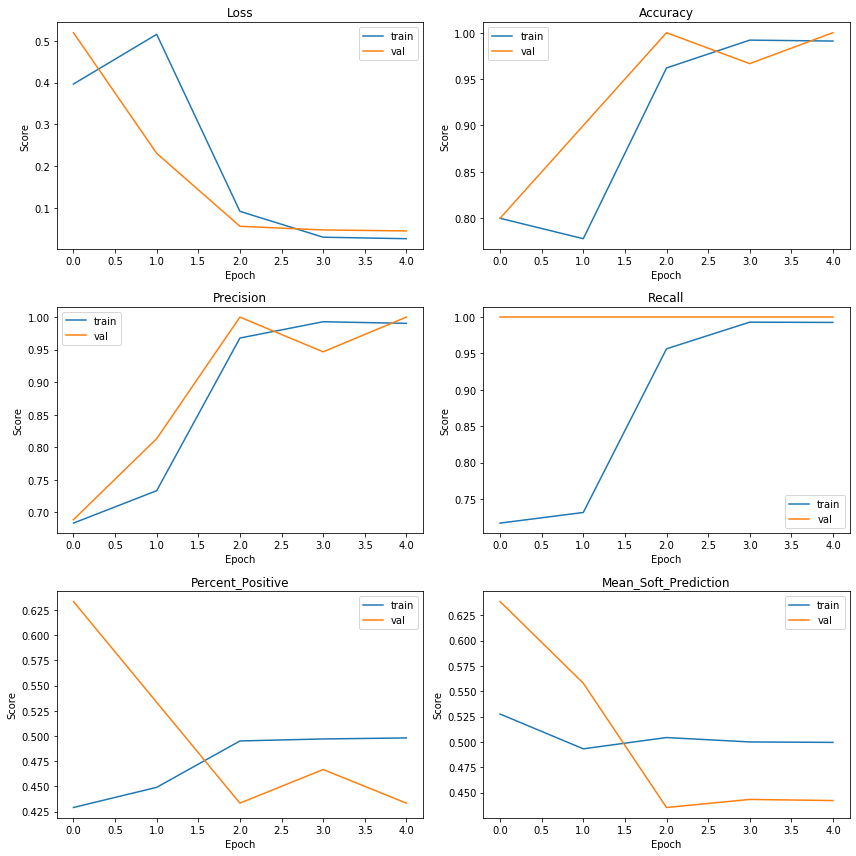

In [ ]:
t.fit(5, 3e-1, 0.5, clean=True)

In [ ]:
t.save('trainer.zip')

Data written to ../data/v1/trainer.zip.


In [ ]:
t2 = Trainer.from_file(os.path.join('..', 'data', 'v1', 'trainer.zip'))
print(t2)
del t2; gc.collect()

Object loaded from ../data/v1/trainer.zip.
Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1')

Datasets: 300 train rows, 30 val rows

Optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.015052040053751204
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.030104080107502408
    momentum: 0
    weight_decay: 0
)

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))


19995

In [ ]:
try:
    for i in range(10):
        time.sleep(1)
        print(i)
except KeyboardInterrupt:
    print('Interrupt')

0
1
Interrupt


## Multiclass classification

In [ ]:
class SimpleMulticlassModel(BaseModel):
    
    def __init__(self, dim, classes):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 10)
        self.fc2 = nn.Linear(10, classes)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
DIM = 2
metrics = [accuracy_score,
           mean_soft_prediction
          ]

callbacks = [
#              EarlyStopper('accuracy', 'max', patience=10),
             PerformanceThreshold('loss', 'min', 2, skip_epochs=5),
             MetricHistory(),
             ModelCheckpoint(),
             MetricHistory(),
             CosineLRScheduler(),
             S3Uploader('gg-datascience', 'hmamin/incendio/v2')
            ]

In [ ]:
train = MulticlassData(n=88, dim=DIM)
val = MulticlassData(n=40, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
smnet = SimpleMulticlassModel(DIM, 5)
t = Trainer(smnet, train, val, dl_train, dl_val, 
            F.cross_entropy, 'multiclass', '../data/v1',
            last_act=F.softmax, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='cross_entropy', out_dir='../data/v1')

Datasets: 88 train rows, 40 val rows

Optimizer: None

SimpleMulticlassModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.3
    weight_decay: 0
)




2020-02-19 16:50:12,246
 
=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.5746 |       1.5252 |
| accuracy             |  0.2273 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,247
 Saving model. Loss improved from inf to 1.5252.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,286
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4841 |       1.5531 |
| accuracy             |  0.3636 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,445
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4658 |       1.5053 |
| accuracy             |  0.2841 |       0.2750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,446
 Saving model. Loss improved from 1.5252 to 1.5053.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,486
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4311 |       1.4825 |
| accuracy             |  0.3523 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,487
 Saving model. Loss improved from 1.5053 to 1.4825.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,528
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3938 |       1.4890 |
| accuracy             |  0.3182 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,567
 
=====

Epoch 5

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3632 |       1.4671 |
| accuracy             |  0.3295 |       0.3750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,568
 Saving model. Loss improved from 1.4825 to 1.4671.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,607
 
=====

Epoch 6

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3797 |       1.5319 |
| accuracy             |  0.3750 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,645
 
=====

Epoch 7

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4439 |       1.4302 |
| accuracy             |  0.2500 |       0.3750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,646
 Saving model. Loss improved from 1.4671 to 1.4302.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,683
 
=====

Epoch 8

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4423 |       1.4877 |
| accuracy             |  0.3750 |       0.2750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,720
 
=====

Epoch 9

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4118 |       1.4260 |
| accuracy             |  0.2614 |       0.3750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,721
 Saving model. Loss improved from 1.4302 to 1.4260.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,762
 
=====

Epoch 10

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3246 |       1.6506 |
| accuracy             |  0.3409 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,800
 
=====

Epoch 11

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4122 |       1.4588 |
| accuracy             |  0.3636 |       0.2250 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,838
 
=====

Epoch 12

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3587 |       1.5368 |
| accuracy             |  0.3750 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,879
 
=====

Epoch 13

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3318 |       1.4431 |
| accuracy             |  0.3523 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,918
 
=====

Epoch 14

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3460 |       1.4037 |
| accuracy             |  0.3636 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,919
 Saving model. Loss improved from 1.4260 to 1.4037.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,959
 
=====

Epoch 15

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3139 |       1.4650 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,000
 
=====

Epoch 16

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3258 |       1.4417 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,039
 
=====

Epoch 17

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2968 |       1.4104 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,079
 
=====

Epoch 18

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2847 |       1.4272 |
| accuracy             |  0.3977 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,117
 
=====

Epoch 19

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2826 |       1.4363 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:13,118
 Training complete. Model in eval mode.


  0%|          | 0/5 [00:00<?, ?it/s]


2020-02-19 16:50:13,808
 Failed to upload ../data/v1/train.log to gg-datascience/hmamin/incendio/v2/train.log: An error occurred (ExpiredToken) when calling the PutObject operation: The provided token has expired.


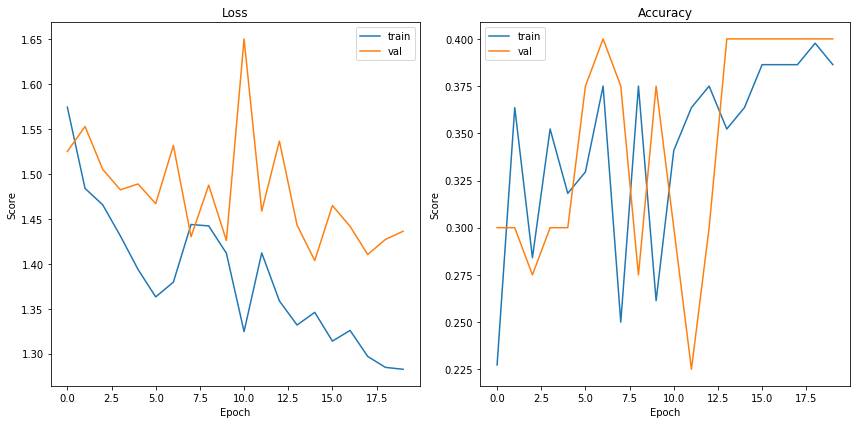

In [ ]:
t.fit(20, .3)

## Easy binary classification

In [ ]:
DIM = 2
metrics = [accuracy_score,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [
    MetricHistory(),
    ModelCheckpoint(),
    MetricHistory(),
]

In [ ]:
train = EasyDataset(400, 100)
val = EasyDataset(40, 100)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
snet = SimpleModel(1)
t = Trainer(snet, train, val, dl_train, dl_val, 
            F.binary_cross_entropy_with_logits, 'multiclass', '../data/v1', 
            last_act=torch.sigmoid, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1')

Datasets: 400 train rows, 40 val rows

Optimizer: None

SimpleModel(
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.1
    weight_decay: 0
)




2020-02-19 16:53:31,492
 
=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.6242 |       0.4281 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4767 |       0.4384 |

=====

2020-02-19 16:53:31,492
 Saving model. Loss improved from inf to 0.4281.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,576
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.2702 |       0.1758 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4262 |       0.5940 |

=====

2020-02-19 16:53:31,577
 Saving model. Loss improved from 0.4281 to 0.1758.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,653
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1424 |       0.1053 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4689 |       0.5977 |

=====

2020-02-19 16:53:31,654
 Saving model. Loss improved from 0.1758 to 0.1053.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,734
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0963 |       0.0617 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4778 |       0.5728 |

=====

2020-02-19 16:53:31,734
 Saving model. Loss improved from 0.1053 to 0.0617.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,812
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0894 |       0.0497 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4825 |       0.5574 |

=====

2020-02-19 16:53:31,812
 Saving model. Loss improved from 0.0617 to 0.0497.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,890
 
=====

Epoch 5

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0752 |       0.0413 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4840 |       0.5723 |

=====

2020-02-19 16:53:31,891
 Saving model. Loss improved from 0.0497 to 0.0413.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,970
 
=====

Epoch 6

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0694 |       0.0355 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4844 |       0.5674 |

=====

2020-02-19 16:53:31,972
 Saving model. Loss improved from 0.0413 to 0.0355.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:32,051
 
=====

Epoch 7

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0642 |       0.0316 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4819 |       0.5716 |

=====

2020-02-19 16:53:32,051
 Saving model. Loss improved from 0.0355 to 0.0316.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:32,128
 
=====

Epoch 8

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0623 |       0.0731 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4835 |       0.6086 |

=====




2020-02-19 16:53:32,208
 
=====

Epoch 9

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0514 |       0.0296 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4870 |       0.5620 |

=====

2020-02-19 16:53:32,209
 Saving model. Loss improved from 0.0316 to 0.0296.
Data written to ../data/v1/trainer.pkl.

2020-02-19 16:53:32,211
 Training complete. Model in eval mode.


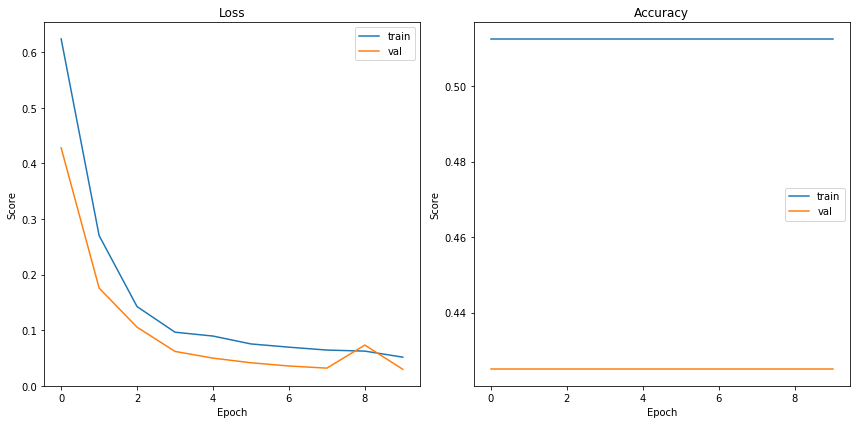

In [ ]:
t.fit(10, .1)

### Scratch

In [ ]:
import inspect

In [ ]:
[getattr(t, k, None) for k in inspect.signature(Trainer).parameters]

[SimpleModel(
   (fc1): Linear(in_features=1, out_features=2, bias=True)
   (fc2): Linear(in_features=2, out_features=1, bias=True)
 ),
 <function torch.nn.functional.binary_cross_entropy_with_logits(input, target, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)>,
 'multiclass',
 '../data/v1',
 torch.optim.adam.Adam,
 0.001,
 <function _VariableFunctions.sigmoid>,
 None,
 [<function incendio.metrics.batch_size(y_true, y_pred)>,
  <function sklearn.metrics._classification.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)>,
  <function incendio.metrics.mean_soft_prediction(y_true, y_score)>],
 {'BasicConfig': BasicConfig(priority=0),
  'StatsHandler': StatsHandler(priority=5),
  'MetricPrinter': MetricPrinter(priority=10),
  'ModelCheckpoint': ModelCheckpoint(priority=25, metric='loss'),
  'MetricHistory': MetricHistory(fname='history.csv', plot_fname='history.png', priority=90)},
 device(type='cpu')]

In [ ]:
from spellotape.dl import inverse_sigmoid

In [ ]:
inverse_sigmoid(.625)

0.5108256237659907

In [ ]:
*x, y = next(iter(dl_train))
x, y

In [ ]:
yhat = smnet(*x)
yhat

In [ ]:
y.shape, yhat.shape

In [ ]:
F.softmax(yhat, dim=-1)

In [ ]:
yhat.shape, y.shape

In [ ]:
F.cross_entropy(yhat, y)

In [ ]:
t = Trainer(smnet, train, val, dl_train, dl_val, F.cross_entropy, 'multiclass',
        '../data/v2', 'datascience-delphi-dev', last_act=partial(F.softmax, dim=-1),
            metrics=metrics, callbacks=callbacks)
t

In [ ]:
import time
from functools import wraps

def catch_keyboard_interrupt(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except KeyboardInterrupt:
            print('interrupt', dir(func))
            # This sets a class variable, not an instance var. Works but not ideal.
            setattr(eval(Foo.bar.__qualname__.split('.')[0]), 'stop', True)
        return
    return wrapper


def catch_method_interrupt(meth_name):
    def decorator(cls):
        func = getattr(cls, meth_name)
        print(func)
        @wraps(func)
        def wrapper(*args, **kwargs):
            print(args, kwargs)
            try:
                func(*args, **kwargs)
            except KeyboardInterrupt:
                print('interrupt', dir(func))
                # This sets a class variable, not an instance var. Works but not ideal.
                setattr(cls, 'stop', True)
            return
        return wrapper
    return decorator


class Foo:
    
    def __init__(self, a):
        self.a = a
        
    @catch_keyboard_interrupt
    def bar(self, b=3):
        for i in range(b):
            time.sleep(1)
            print(self.a)
            

@catch_method_interrupt('train')
class Fizz:

        def __init__(self, a):
            self.a = a
            
        def walk(self, t=5):
            for i in range(t):
                time.sleep(1)
                print(i)
                
        def train(self, epochs):
            for e in epochs:
                print(e)
                time.sleep(1)

<function Fizz.train at 0x14264a0e0>


In [ ]:
f = Foo(5)
f.__dict__

{'a': 5}

In [ ]:
f.bar()

5
interrupt ['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [ ]:
f.__dict__

{'a': 5}

In [ ]:
Foo.stop

True

In [ ]:
f.stop

True

In [ ]:
fizz = Fizz(6)
fizz.walk()

(6,) {}


TypeError: train() missing 1 required positional argument: 'epochs'